In [1]:
!pip install -q --upgrade bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install datasets
!pip install torch
!pip install evaluate
! pip install -U datasets huggingface-hub
! pip install rouge_score

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=7067560b29c802ac386918d586cacb90282d5290a83752a90035439ae154177d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import pandas as pd
import re
import transformers
print(transformers.__version__)
import huggingface_hub
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForCausalLM
from transformers import  Trainer, TrainingArguments
from accelerate import init_empty_weights,infer_auto_device_map
import torch
import evaluate
import torch
import numpy as np

4.34.0.dev0


In [3]:
from datasets import load_dataset

dataset = load_dataset("anujsahani01/Custom_dataset")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 139924
    })
    validation: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 46642
    })
    test: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 46642
    })
})

In [ ]:
train_prompts = dataset['train']['text_prompt']
test_prompts = dataset['test']['text_prompt']
validation_prompts = dataset['validation']['text_prompt']

train_code = dataset['train']['code_prompt']
test_code = dataset['test']['code_prompt']
validation_code = dataset['validation']['code_prompt']

print(len(train_prompts) == len(train_code))
print(len(test_prompts) == len(test_code))
print(len(validation_prompts) == len(validation_code))
print('----------------------------------------------')
print(None in train_prompts)
print(None in test_prompts)
print(None in validation_prompts)
print(None in train_code)
print(None in test_code)
print(None in validation_code)

True
True
True
----------------------------------------------
True
False
False
True
False
True


In [ ]:
train_prompts = dataset['train']['text_prompt']
test_prompts = dataset['test']['text_prompt']
validation_prompts = dataset['validation']['text_prompt']

train_code = dataset['train']['code_prompt']
test_code = dataset['test']['code_prompt']
validation_code = dataset['validation']['code_prompt']

final_train_prompts = []
final_test_prompts = []
final_validation_prompts = []

final_train_code = []
final_test_code = []
final_validation_code = []

if None in train_prompts or None in train_code:
    for i in range(len(train_prompts)):
        if train_prompts[i] is not None and train_code[i] is not None:
            final_train_prompts.append(train_prompts[i])
            final_train_code.append(train_code[i])
else:
    final_train_prompts = train_prompts
    final_train_code = train_code

if None in test_prompts or None in test_code:
    for i in range(len(test_prompts)):
        if test_prompts[i] is not None and test_code[i] is not None:
            final_test_prompts.append(test_prompts[i])
            final_test_code.append(test_code[i])
else:
    final_test_prompts = test_prompts
    final_test_code = test_code

if None in validation_prompts or None in validation_code:
    for i in range(len(validation_prompts)):
        if validation_prompts[i] is not None and validation_code[i] is not None:
            final_validation_prompts.append(validation_prompts[i])
            final_validation_code.append(validation_code[i])
else:
    final_validation_prompts = validation_prompts
    final_validation_code = validation_code

In [ ]:
print(None in final_train_prompts)
print(None in final_test_prompts)
print(None in final_validation_prompts)
print(None in final_train_code)
print(None in final_test_code)
print(None in final_validation_code)

False
False
False
False
False
False


In [ ]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

df_train['text_prompt'] = final_train_prompts
df_train['code_prompt'] = final_train_code
df_test['text_prompt'] = final_test_prompts
df_test['code_prompt'] = final_test_code
df_val['text_prompt'] = final_validation_prompts
df_val['code_prompt'] = final_validation_code

In [ ]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({
    'train' :  Dataset.from_pandas(df_train),
    'test' :  Dataset.from_pandas(df_test),
    'validation' :  Dataset.from_pandas(df_val)
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 139921
    })
    test: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 46642
    })
    validation: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 46631
    })
})

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# special tokens for prompting
system_token = "<SYSTEM_TASK:>"
user_token = "<USER_TASK:>"
assistant_token = "<ASSISTANT_TASK:>"
end_token = "<END_TASK>"


tokenizer = AutoTokenizer.from_pretrained("codeparrot/codeparrot",
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<PAD>",
                                          )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='codeparrot/codeparrot', vocab_size=32768, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True)

In [ ]:
special_token_dict = tokenizer.special_tokens_map
print(special_token_dict)

{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}


In [ ]:
tokenizer.add_special_tokens(special_token_dict)

0

In [ ]:
def dataset_LM(data):
    final = data['text_prompt'] + '\n' + data['code_prompt']
    return{
        'final_input' : final
    }

LM_final_dataset = dataset.map(dataset_LM, batched = False, remove_columns = dataset['train'].column_names)

LM_final_dataset

Map:   0%|          | 0/139921 [00:00<?, ? examples/s]

Map:   0%|          | 0/46642 [00:00<?, ? examples/s]

Map:   0%|          | 0/46631 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['final_input'],
        num_rows: 139921
    })
    test: Dataset({
        features: ['final_input'],
        num_rows: 46642
    })
    validation: Dataset({
        features: ['final_input'],
        num_rows: 46631
    })
})

In [ ]:
context_length = 1000
def tokenize(data):
    return tokenizer(data['final_input'],
#                       padding = 'max_length',
                      truncation=True,)
#                       max_length = context_length)

tokenized_dataset = LM_final_dataset.map(tokenize, batched = True, remove_columns = LM_final_dataset['train'].column_names)

Map:   0%|          | 0/139921 [00:00<?, ? examples/s]

Map:   0%|          | 0/46642 [00:00<?, ? examples/s]

Map:   0%|          | 0/46631 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 139921
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 46642
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 46631
    })
})

In [ ]:
print(len(tokenized_dataset['train'][10]['input_ids']))

243


In [ ]:
block_size = 1000


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
final_tokenized_dataset = tokenized_dataset.map(group_texts, batched = True)
final_tokenized_dataset

Map:   0%|          | 0/139921 [00:00<?, ? examples/s]

Map:   0%|          | 0/46642 [00:00<?, ? examples/s]

Map:   0%|          | 0/46631 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33986
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11326
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 22136
    })
})

In [ ]:
import huggingface_hub
huggingface_hub.notebook_login()

In [ ]:
final_tokenized_dataset.push_to_hub('anujsahani01/CodeParrot_tokenized')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/34 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

   **RESTART RUNTIME AS RAM IS FULL**

In [4]:
import pandas as pd
import re
import transformers
print(transformers.__version__)
import huggingface_hub
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForCausalLM
from transformers import  Trainer, TrainingArguments
from accelerate import init_empty_weights,infer_auto_device_map
import torch
import evaluate
import torch
import numpy as np

4.34.0.dev0


In [5]:
from datasets import load_dataset
final_tokenized_dataset = load_dataset("anujsahani01/CodeParrot_tokenized")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/11326 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/33986 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22136 [00:00<?, ? examples/s]

In [6]:
final_tokenized_dataset

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11326
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33986
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 22136
    })
})

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# special tokens for prompting
system_token = "<SYSTEM_TASK:>"
user_token = "<USER_TASK:>"
assistant_token = "<ASSISTANT_TASK:>"
end_token = "<END_TASK>"


tokenizer = AutoTokenizer.from_pretrained("codeparrot/codeparrot-small",
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<|PAD|>",
                                          model_max_length = 5000
                                          )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='codeparrot/codeparrot-small', vocab_size=32768, model_max_length=5000, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|PAD|>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True)


In [7]:
special_tokens = list(tokenizer.additional_special_tokens)
tokenizer.add_tokens(special_tokens)
print(tokenizer.vocab_size)

32768


In [8]:
len(tokenizer)

32773

In [9]:
context_length = 3000

In [10]:
config = AutoConfig.from_pretrained("codeparrot/codeparrot-small",
                                    vocab_size= len(tokenizer),
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    n_ctx = context_length,
                                    model_max_length = 3000
)

with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)

print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(32773, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=32773, bias=False)
)


In [11]:
device_map = infer_auto_device_map(model, no_split_module_classes = ['GPT2Block'])
print(device_map)

{'': 0}


In [12]:
import torch
from transformers import BitsAndBytesConfig, AutoConfig

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16,
   n_ctx = context_length
)


# model_id = "codeparrot/codeparrot"
model_id = "codeparrot/codeparrot-small"
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            config = config,
                                            # device_map="auto",
                                            quantization_config=nf4_config,
                                            torch_dtype=torch.bfloat16)

In [13]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32773. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(32773, 768)

Testing the score of the original model

In [14]:
from transformers import GenerationConfig
prompts = dataset['test'][0:10]['text_prompt']
human_baseline_codes = dataset['test'][0:10]['code_prompt']

orignal_model_codes = []
generation_config = GenerationConfig(max_new_tokens=200, temperature= 0.5, do_sample=True, top_p = 5)

for _, prompt in enumerate(prompts):
    prompt = f"""
<SYSTEM_TASK:>\nGiven the following code description, write Python code to implement the functionality described below\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
{prompt}
"""
    input = tokenizer(prompt, return_tensors="pt")
    orignal_model_outputs = model.generate(input['input_ids'], generation_config=generation_config ,  pad_token_id = tokenizer.pad_token_id)
    orignal_model_text_output = tokenizer.decode(orignal_model_outputs[0], skip_special_tokens=True)
    orignal_model_codes.append(orignal_model_text_output)

zipped_summaries = list(zip(human_baseline_codes, orignal_model_codes))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_codes', 'orignal_model_codes'])
df

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1535: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


,human_baseline_codes,orignal_model_codes
0,\n s = con_end + read_or_write\n ...,"\n\nGiven the following code description, writ..."
1,"\n oui = "":"".join(mac.split("":"")[:3]).u...","\n\nGiven the following code description, writ..."
2,"\n if not hasattr(other, ""ctr""):\n ...","\n\nGiven the following code description, writ..."
3,\n if not os.path.isdir(os.path.join(os.pat...,"\n\nGiven the following code description, writ..."
4,"\n tmp_len = struct.unpack(""!H"", m[2:4])[0]...","\n\nGiven the following code description, writ..."
5,\n ct = AnsiColorTheme() if dump else c...,"\n\nGiven the following code description, writ..."
6,"\n _fields_desc = []\n for j, k in lengt...","\n\nGiven the following code description, writ..."
7,\n # Dataflowset definitions\n if Netflo...,"\n\nGiven the following code description, writ..."
8,"\n pem_strings = []\n while s != b"""":\n ...","\n\nGiven the following code description, writ..."
9,\n tbsCert = cert.tbsCertificate\n ...,"\n\nGiven the following code description, writ..."


In [15]:
rouge = evaluate.load('rouge')

In [16]:
orignal_model_results = rouge.compute(
    predictions=orignal_model_codes,
    references=human_baseline_codes[0:len(orignal_model_codes)],
    use_aggregator=True,
    use_stemmer=True,
)

print(orignal_model_results)

{'rouge1': 0.12197070234708277, 'rouge2': 0.025755560987680108, 'rougeL': 0.0909880303275154, 'rougeLsum': 0.1201494177824305}


In [14]:
from peft import get_peft_config, LoraConfig, TaskType, prepare_model_for_int8_training, get_peft_model
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [15]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=64,
    target_modules=["c_attn"],
    lora_dropout=0.4,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [16]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32773. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(32773, 768)

In [19]:
model.print_trainable_parameters()

trainable params: 294,912 || all params: 111,307,008 || trainable%: 0.2649536676073442


In [20]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [21]:
training_args = TrainingArguments(
    output_dir='./PyLoomer_CodeParrot',          # output directory
    num_train_epochs= 2,             # total number of training epochs
    per_device_train_batch_size=6,   # batch size per device during training
    per_device_eval_batch_size=6,   # batch size for evaluation
    warmup_steps=80,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    learning_rate= 0.0001,
    max_steps = 8500,
    fp16= True,
    push_to_hub=True,
)

In [22]:
### Metrics
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-22-b4ddd7f6e636>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [23]:
# import huggingface_hub
# huggingface_hub.notebook_login()

In [24]:
# ! huggingface-cli login

In [25]:
trainer = Trainer(
    model=model.to('cuda'),
    args=training_args,
    train_dataset=final_tokenized_dataset["train"],
    eval_dataset=final_tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

In [26]:
model.config.use_cache = False

In [27]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.614400
1000,1.546000
1500,1.538600
2000,1.537300
2500,1.537000
3000,1.526200
3500,1.536700
4000,1.529800
4500,1.526500
5000,1.515200


TrainOutput(global_step=8500, training_loss=1.5343647891773897, metrics={'train_runtime': 11040.8603, 'train_samples_per_second': 4.619, 'train_steps_per_second': 0.77, 'total_flos': 1.3121347497984e+16, 'train_loss': 1.5343647891773897, 'epoch': 1.5})

In [28]:
# model.save_pretrained("anujsahani01/PyLoomer_CodeParrot")
# tokenizer.save_pretrained("anujsahani01/PyLoomer_CodeParrot")

In [29]:
metrics = trainer.state.log_history

In [30]:
train_loss = []
steps = []
for i in range(len(metrics)-1):
  train_loss.append(metrics[i]['loss'])
  steps.append(metrics[i]['step'])

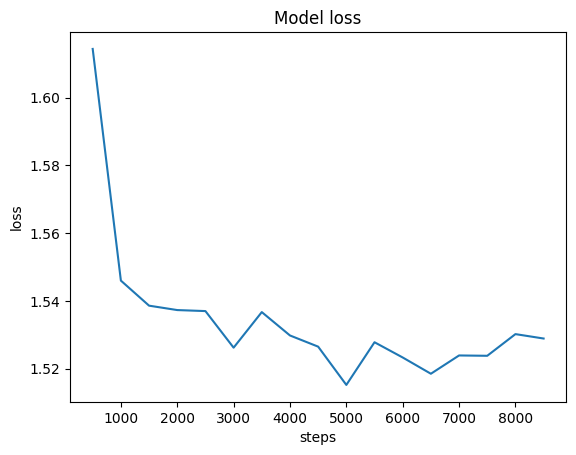

In [31]:
import matplotlib.pyplot as plt

plt.plot(steps, train_loss)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()

In [32]:
trainer.push_to_hub()

'https://huggingface.co/anujsahani01/PyLoomer_CodeParrot/tree/main/'

In [33]:
from transformers import AutoModelForCausalLM, pipeline

model_ckpt = "anujsahani01/PyLoomer_CodeParrot"
model = AutoModelForCausalLM.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:310: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [34]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32773. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(32773, 768)

In [35]:
tokenizer = AutoTokenizer.from_pretrained("anujsahani01/PyLoomer_CodeParrot",
                                          vocab_size = len(tokenizer),
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<PAD>",
                                          model_max_length = 3000
                                          )

print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2TokenizerFast(name_or_path='anujsahani01/PyLoomer_CodeParrot', vocab_size=32768, model_max_length=3000, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True)


In [36]:
add_prompt = '<SYSTEM_TASK:>\nGiven the following code description, write Python code to implement the functionality described below\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
text_prompt = 'def VGG16_model_architecture()\n"""\nInitialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function\n"""\n\bdef train_test_split():\n\t"""Split the data X, Y in to train and test data using sklearn"""\n\bdef model_predict():\n\t"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""\n'

final_prompt = add_prompt + text_prompt

In [37]:
# pad_token_id = tokenizer.pad_token_id

In [38]:
pipe = pipeline('text-generation', model = model_ckpt)
print(pipe(final_prompt, num_return_sequences=1, max_new_tokens = 150)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<SYSTEM_TASK:>
Given the following code description, write Python code to implement the functionality described below
<END_TASK>
<USER_TASK:>
Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function
"""
def train_test_split():
	"""Split the data X, Y in to train and test data using sklearn"""
def model_predict():
	"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""
	# create deep training sets
	X, Y, n_input_data = X.shape
	print '\nX shape: %d' % X.shape
	X_train, Y_train, X_test, Y_test = X[:n_input_data], Y[:n_input_data], X[n_input_data:]
	rectangle(X_train, Y_train, X_test)#--this is not a line due to floating points getting around - very low precision the first point is very better (it is faster)

####### EXAMPLE1-----------------------------------------------------------------#
# # Create a simpl

In [39]:
from transformers import GenerationConfig
inputs = tokenizer(final_prompt, return_tensors = 'pt')
generation_config = GenerationConfig(max_new_tokens=200, temperature= 0.5, do_sample=True, top_p = 5)

output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens = 200,
        generation_config=generation_config,
        pad_token_id = tokenizer.pad_token_id,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{final_prompt}')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<SYSTEM_TASK:>
Given the following code description, write Python code to implement the functionality described below
<END_TASK>
<USER_TASK:>
Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function
"""
def train_test_split():
	"""Split the data X, Y in to train and test data using sklearn"""
def model_predict():
	"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:

Given the following code description, write Python code to implement the functionality described below


Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model tr

In [41]:
rouge = evaluate.load('rouge')

In [42]:
model.config.pad_token_id = tokenizer.pad_token_id = tokenizer.unk_token_id

In [46]:
prompts = dataset['test'][0:10]['text_prompt']
human_baseline_codes = dataset['test'][0:10]['code_prompt']

finetuned_model_codes = []
generation_config = GenerationConfig(max_new_tokens=200, temperature= 0.5, do_sample=True, top_p = 5)

for _, prompt in enumerate(prompts):
    prompt = f"""
<SYSTEM_TASK:>\nGiven the following code description, write Python code to implement the functionality described below\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
{prompt}
"""
    input = tokenizer(prompt, return_tensors="pt")
    finetuned_model_outputs = model.generate(input['input_ids'], generation_config=generation_config ,  pad_token_id = tokenizer.pad_token_id)
    finetuned_model_text_output = tokenizer.decode(finetuned_model_outputs[0], skip_special_tokens=True)
    finetuned_model_codes.append(finetuned_model_text_output)

zipped_summaries = list(zip(human_baseline_codes, finetuned_model_codes))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_codes', 'finetuned_model_codes'])
df

,human_baseline_codes,finetuned_model_codes
0,\n s = con_end + read_or_write\n ...,"\n\nGiven the following code description, writ..."
1,"\n oui = "":"".join(mac.split("":"")[:3]).u...","\n\nGiven the following code description, writ..."
2,"\n if not hasattr(other, ""ctr""):\n ...","\n\nGiven the following code description, writ..."
3,\n if not os.path.isdir(os.path.join(os.pat...,"\n\nGiven the following code description, writ..."
4,"\n tmp_len = struct.unpack(""!H"", m[2:4])[0]...","\n\nGiven the following code description, writ..."
5,\n ct = AnsiColorTheme() if dump else c...,"\n\nGiven the following code description, writ..."
6,"\n _fields_desc = []\n for j, k in lengt...","\n\nGiven the following code description, writ..."
7,\n # Dataflowset definitions\n if Netflo...,"\n\nGiven the following code description, writ..."
8,"\n pem_strings = []\n while s != b"""":\n ...","\n\nGiven the following code description, writ..."
9,\n tbsCert = cert.tbsCertificate\n ...,"\n\nGiven the following code description, writ..."


In [47]:
finetuned_model_results = rouge.compute(
    predictions=finetuned_model_codes,
    references=human_baseline_codes[0:len(finetuned_model_codes)],
    use_aggregator=True,
    use_stemmer=True,
)

print(finetuned_model_results)

{'rouge1': 0.16562512703482807, 'rouge2': 0.04115342044386752, 'rougeL': 0.1145960047211397, 'rougeLsum': 0.16262131773754435}


## Certainly, let's confirm once again and calculate the overall best score by averaging the values for the four metrics (rouge1, rouge2, rougeL, and rougeLsum) for both sets:

# Finetuned Model:

Average score = (0.16562512703482807 + 0.04115342044386752 + 0.1145960047211397 + 0.16262131773754435) / 4

**Average score ≈ 0.12149821798434416**

# Orignal Model:

Average score = (0.12197070234708277 + 0.025755560987680108 + 0.0909880303275154 + 0.1201494177824305) / 4

**Average score ≈ 0.0894654273616777**


Comparing the average scores, Set 1 has a higher average score (approximately 0.1215) compared to Set 2 (approximately 0.0895).

Therefore, the overall best score is from Set 1, with an average score of approximately 0.1215.